In [86]:
import torch
import esm
import torch.nn as nn
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import utils 
import importlib 
importlib.reload(utils)
import pandas as pd
import numpy as np
import os

In [69]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12], return_contacts=True)
token_representations = results["representations"][12]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

In [90]:
df = pd.read_excel("/home/tyfei/datasets/ion_channel/Interprot/Interprot-ion-channel-judgement.xls")
df = df.set_index("Accession")
df
# df.loc[["IPR006859", "IPR008187", "IPR043506", "IPR043507"]]

,Name,Description,Source Database,Has_Transmembrane_Region
Accession,,,,
SM01420,Transient receptor ion channel II,This domain is found in the transient receptor...,SMART,True
PF08344,Transient receptor ion channel II,This domain is found in the transient receptor...,PFAM,True
IPR013555,Transient receptor ion channel domain,This domain is found in a group of Trp protein...,INTERPRO,True
IPR024393,"Mechanosensitive ion channel MscS, porin domain","The small mechanosensitive channel, MscS, is a...",INTERPRO,True
PF12794,Mechanosensitive ion channel inner membrane do...,"The small mechanosensitive channel, MscS, is a...",PFAM,True
...,...,...,...,...
IPR001069,5-Hydroxytryptamine 7 receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True
IPR002232,5-Hydroxytryptamine 6 receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True
IPR000377,5-Hydroxytryptamine 2C receptor,"5-hydroxytryptamine (5-HT) or serotonin, is a ...",INTERPRO,True


In [70]:
seqs = {} 
seqs["virus_seq"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Known_Virus_Ion_pro/all_Known_Virus_Ion_pro.rename_0.99.fasta", trunc=1200) 
# seqs["negative"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Interprot/Negative_sample/decoy_1m_new.fasta", 30000, 1200)

In [91]:
lens = [] 
for j in seqs:
    lens.append(len(seqs[j]))
    # for i in seqs[j]:
    #     lens.append(len(i[1]))
    #     if len(i[1]) > 1300:
    #         print(j, len(i[1]), i)
len(lens), np.max(lens)

(207, 159463)

(array([126.,  19.,  13.,   9.,   4.,   6.,   2.,   4.,   1.,   3.,   1.,
          4.,   0.,   0.,   3.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.0000000e+00, 1.5956200e+03, 3.1902400e+03, 4.7848600e+03,
        6.3794800e+03, 7.9741000e+03, 9.5687200e+03, 1.1163340e+04,
        1.2757960e+04, 1.4352580e+04, 1.5947200e+04, 1.7541820e+04,
        1.9136440e+04, 2.0731060e+04, 2.2325680e+04, 2.3920300e+04,
        2.5514920e+04, 2.7109540e+04, 2.870416

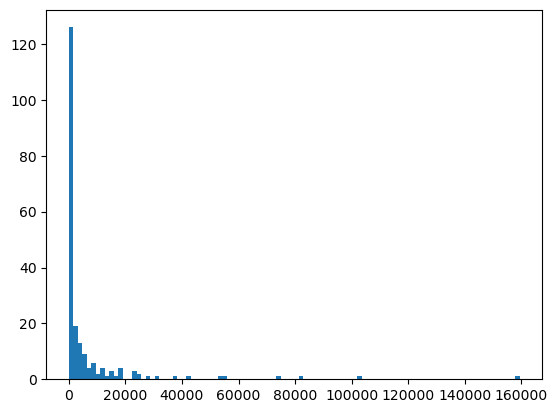

In [92]:
plt.hist(lens, bins=100)

In [87]:
seqs = {}
for i in os.listdir("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/0.99"):
    try:
        if i.endswith(".fas"):
            # print(i, i[:i.find(".")] in df["Accession"].values)
            seqs[i[:i.find(".")]] = utils.readDataset("/home/tyfei/datasets/ion_channel/Interprot/ion_channel/0.99/"+i, trunc=1200)
    except:
        print(i)

In [7]:
filtered = []
labels = [] 

for i, tt in seqs.items():
    labels.extend([i]*len(tt))
    for name, seq in tt:
        if "*" in seq:
            filtered.append((name, seq[:-1].upper()))
        else:
            filtered.append((name, seq.upper()))

In [8]:
batch_labels, _, batch_tokens = batch_converter(filtered)

In [9]:
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
model = model.to("cuda:5")
batch_tokens = batch_tokens.to("cuda:5")
# Extract per-residue representations (on CPU)
allres = []
for i in tqdm(range(0,len(batch_tokens), 10)):
    with torch.no_grad():
        results = model(batch_tokens[i:i+10], repr_layers=[12], return_contacts=False)
        token_representations = results["representations"][12].cpu().numpy()
        allres.append(token_representations)

100%|██████████| 6787/6787 [21:55<00:00,  5.16it/s]


In [10]:
import numpy as np 
allres = np.concatenate(allres, axis=0)
allres.shape

(67862, 1202, 480)

In [11]:
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(allres[i, 1 : tokens_len - 1].mean(0))
sequence_representations = np.array(sequence_representations)
# sequence_representations

In [12]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=20) 
pca_seq = pca.fit_transform(sequence_representations)
pca_seq.shape

(67862, 20)

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

In [25]:
df = pd.DataFrame({"x":X_embedded[:, 0], "y":X_embedded[:, 1], "labels":labels})
mapping = {}
for i in np.unique(df["labels"]):
    mapping[i] = len(mapping)
df["labels"] = df["labels"].apply(lambda x: "negative" if x == "nagative" else x)
df["c"] = df["labels"].map(mapping)
df["negative"] = (df["labels"] == "negative").astype(int)
df["virus_seq"] = (df["labels"] == "virus_seq").astype(int)

In [27]:
df.to_csv("./temp/data.csv")

In [4]:
df = pd.read_csv("./temp/data.csv")

In [ ]:
subdf = df[df["labels"] != "negative"]
for i in np.unique(df["labels"]):
    if i == "negative":
        continue
    if i == "virus_seq":
        continue
    print(i)
    subdf["draw"] = (subdf["labels"] == i).astype(int)
    # subdf = df[df["labels"] != "negative"] 
    # subdf = subdf[subdf["virus_seq"] == i]
    plt.scatter(subdf["x"], subdf["y"], c=subdf["draw"], label=subdf["draw"], s=5)
    plt.show()
    plt.close()

0
1


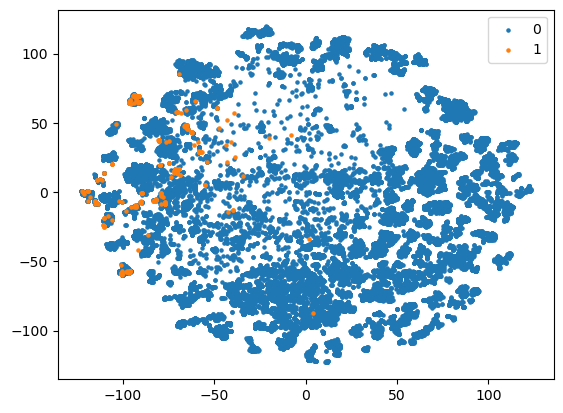

In [29]:
# c = [0]*50000+[1]*369 
for i in np.unique(df["virus_seq"]):
    # if i == "negative":
    #     continue
    # if i == "virus_seq":
    #     continue
    print(i)
    subdf = df[df["labels"] != "negative"] 
    subdf = subdf[subdf["virus_seq"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, s=5)
plt.legend(bbox_to_anchor=(1,1))

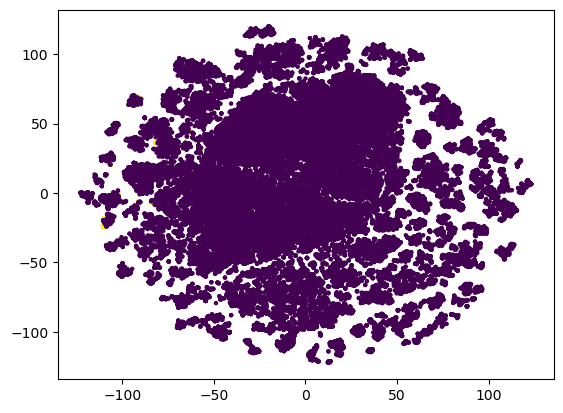

In [116]:
plt.scatter(df["x"], df["y"], c=df["virus_seq"], s=5)

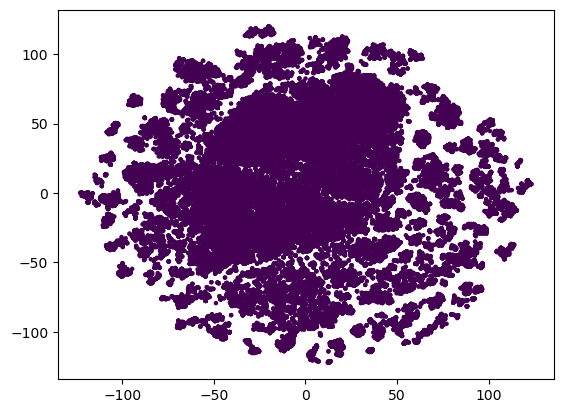

In [117]:
plt.scatter(df["x"], df["y"], c=df["negative"], s=5)